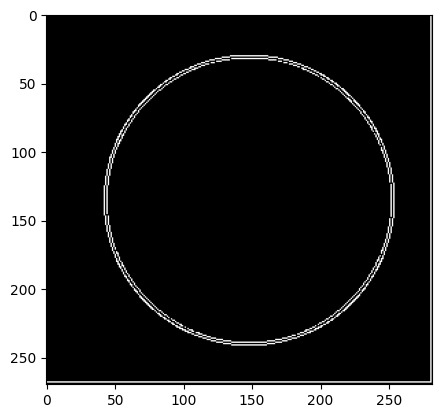

In [89]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

# Load the image
# img = plt.imread('../images/shape.jpeg', 0)

# Load the image
o_img = cv2.imread('../images/ccc.png')
img= cv2.cvtColor(o_img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
img = cv2.Canny(img, 300, 500)


plt.imshow(img, cmap='gray')

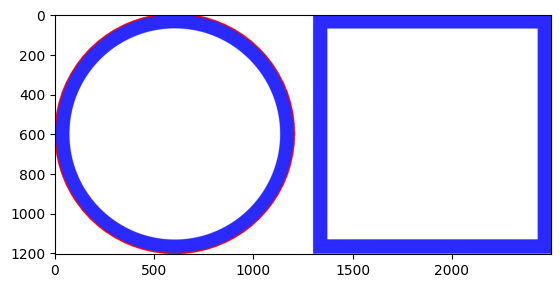

In [277]:
# Load the image
o_img = cv2.imread('../images/cs.png')
img= cv2.cvtColor(o_img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
img = cv2.Canny(img, 150, 300)

# Detect circles using HoughCircles function
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

# Convert the (x, y) coordinates and radius of the circles to integers
circles = np.round(circles[0, :]).astype("int")

# Draw the circles on the original image
for index in range(len(circles)):
    
    cv2.circle(o_img, (circles[index][0], circles[index][1]), circles[index][2], (255, 0, 0), 5)
    if index==0:
        break


# Display the image
plt.imshow(o_img, cmap='gray')

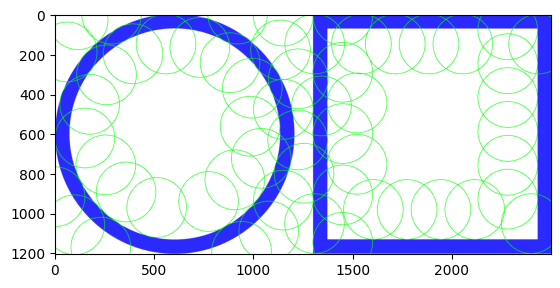

In [293]:
import numpy as np
import math

def hough_circles(image, dp, minDist, minRadius, maxRadius, canny_threshold=100, accumulator_threshold=20):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply the Canny edge detection algorithm
    edges = cv2.Canny(gray, canny_threshold, canny_threshold * 2, apertureSize=3)
    
    # Initialize the accumulator array
    height, width = gray.shape
    acc = np.zeros((height, width, maxRadius - minRadius + 1))
    
    # Precompute sin and cos values for each angle
    sin_values = np.sin(np.arange(0, 2*np.pi, 0.01))
    cos_values = np.cos(np.arange(0, 2*np.pi, 0.01))
    
    # Iterate over each pixel in the edges image
    for y in range(height):
        for x in range(width):
            # If the pixel is an edge pixel
            if edges[y, x] > 0:
                # Iterate over each radius in the specified range
                for r in range(minRadius, maxRadius+1):
                    # Compute the center of the circle for this radius
                    for theta in range(0, len(sin_values)):
                        a = x - r * cos_values[theta]
                        b = y - r * sin_values[theta]
                        
                        # Increment the accumulator array for this circle
                        if a >= 0 and a < width and b >= 0 and b < height:
                            acc[int(b), int(a), r - minRadius] += 1
                            
    # Find the circles with enough votes
    circles = []
    for r in range(maxRadius - minRadius + 1):
        for y in range(height):
            for x in range(width):
                if acc[y, x, r] >= accumulator_threshold:
                    # Check that the circle does not overlap with existing circles
                    is_overlap = False
                    for circle in circles:
                        if math.sqrt((x - circle[0])**2 + (y - circle[1])**2) < circle[2] + r + minDist:
                            is_overlap = True
                            break
                    if not is_overlap:
                        circles.append((x, y, r + minRadius))
    
    # Draw the circles on the original image
    for circle in circles:
        cv2.circle(image, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
    
    return image


# Load the image
image = cv2.imread('../images/cs.png')

# Detect circles using the hough_circles function
image = hough_circles(image, 1, 20, 150, 250)

# Display the image
plt.imshow(image)


In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def find_hough_circles(image, edge_image, r_min, r_max, delta_r, num_thetas, bin_threshold, post_process = True):
  #image size
  img_height, img_width = edge_image.shape[:2]
  
  # R and Theta ranges
  dtheta = int(360 / num_thetas)
  
  ## Thetas is bins created from 0 to 360 degree with increment of the dtheta
  thetas = np.arange(0, 360, step=dtheta)
  
  ## Radius ranges from r_min to r_max 
  rs = np.arange(r_min, r_max, step=delta_r)
  
  # Calculate Cos(theta) and Sin(theta) it will be required later
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  # Evaluate and keep ready the candidate circles dx and dy for different delta radius
  # based on the the parametric equation of circle.
  # x = x_center + r * cos(t) and y = y_center + r * sin(t),  
  # where (x_center,y_center) is Center of candidate circle with radius r. t in range of [0,2PI)
  circle_candidates = []
  for r in rs:
    for t in range(num_thetas):
      #instead of using pre-calculated cos and sin theta values you can calculate here itself by following
      #circle_candidates.append((r, int(r*cos(2*pi*t/num_thetas)), int(r*sin(2*pi*t/num_thetas))))
      #but its better to pre-calculate and use it here.
      circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))
  
  # Hough Accumulator, we are using defaultdic instead of standard dict as this will initialize for key which is not 
  # aready present in the dictionary instead of throwing exception.
  accumulator = defaultdict(int)
  
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0: #white pixel
        # Found an edge pixel so now find and vote for circle from the candidate circles passing through this pixel.
        for r, rcos_t, rsin_t in circle_candidates:
          x_center = x - rcos_t
          y_center = y - rsin_t
          accumulator[(x_center, y_center, r)] += 1 #vote for current candidate
  
  # Output image with detected lines drawn
  output_img = image.copy()
  # Output list of detected circles. A single circle would be a tuple of (x,y,r,threshold) 
  out_circles = []
  
  # Sort the accumulator based on the votes for the candidate circles 
  for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
    x, y, r = candidate_circle
    current_vote_percentage = votes / num_thetas
    if current_vote_percentage >= bin_threshold: 
      # Shortlist the circle for final result
      out_circles.append((x, y, r, current_vote_percentage))
      print(x, y, r, current_vote_percentage)
      
  
  # Post process the results, can add more post processing later.
  if post_process :
    pixel_threshold = 5
    postprocess_circles = []
    for x, y, r, v in out_circles:
      # Exclude circles that are too close of each other
      # all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc, v in postprocess_circles)
      # Remove nearby duplicate circles based on pixel_threshold
      if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in postprocess_circles):
        postprocess_circles.append((x, y, r, v))
    out_circles = postprocess_circles
  
    
  # Draw shortlisted circles on the output image
  for x, y, r, v in out_circles:
    output_img = cv2.circle(output_img, (x,y), r, (0,255,0), 2)
  
  return output_img, out_circles

def main():
    
    # img_path = "C:\\Users\\Omar Saad\\Desktop\\hough_circles\\circles.jpg"
    img_path = "../images/standard.png"
    r_min = 10
    r_max = 200
    delta_r = 1
    num_thetas = 100
    bin_threshold = 0.4
    min_edge_threshold = 100
    max_edge_threshold = 200
    
    input_img = cv2.imread(img_path)
    
    #Edge detection on the input image
    edge_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    #ret, edge_image = cv2.threshold(edge_image, 120, 255, cv2.THRESH_BINARY_INV)
    edge_image = cv2.Canny(edge_image, min_edge_threshold, max_edge_threshold)
    
    # cv2.imshow('Edge Image', edge_image)
    cv2.waitKey(0)
    
    if edge_image is not None:
        
        print ("Detecting Hough Circles Started!")
        circle_img, circles = find_hough_circles(input_img, edge_image, r_min, r_max, delta_r, num_thetas, bin_threshold)
        
        plt.imshow('Detected Circles', circle_img)
        
        
        # circle_file = open('circles_list.txt', 'w')
        # circle_file.write('x ,\t y,\t Radius,\t Threshold \n')
        # for i in range(len(circles)):
        #     circle_file.write(str(circles[i][0]) + ' , ' + str(circles[i][1]) + ' , ' + str(circles[i][2]) + ' , ' + str(circles[i][3]) + '\n')
        # circle_file.close()
        
        # if circle_img is not None:
        #     cv2.imwrite("circles_img.png", circle_img)
    else:
        print ("Error in input image!")
            
    print ("Detecting Hough Circles Complete!")



if __name__ == "__main__":
    main()